In [1]:
!pip install opencv-python

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import cv2
import torch
from torchvision import models, transforms
from matplotlib import pyplot as plt
import numpy as np

In [3]:
def load_inceptionv3_model():
    model = models.inception_v3(pretrained=True)
    model.fc = torch.nn.Identity()  # Retirer la dernière couche de classification
    model.eval()
    return model

In [4]:
def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((299, 299)),  # InceptionV3 prend des images de 299x299
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = preprocess(image).unsqueeze(0)  # Ajouter la dimension batch
    return image_tensor

In [5]:
def extract_features(image, model):
    image_tensor = preprocess_image(image)
    with torch.no_grad():
        embeddings = model(image_tensor)  # Extraire les embeddings
    return embeddings

In [6]:
def display_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [7]:
def detect_faces_opencv(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

In [8]:
def detect_eyes_opencv(face_region):
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    gray_face = cv2.cvtColor(face_region, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray_face, scaleFactor=1.1, minNeighbors=5, minSize=(20, 20))
    return eyes

In [9]:
def align_face(image, left_eye, right_eye):
    left_eye_center = (int(left_eye[0] + left_eye[2] / 2), int(left_eye[1] + left_eye[3] / 2))
    right_eye_center = (int(right_eye[0] + right_eye[2] / 2), int(right_eye[1] + right_eye[3] / 2))

    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]
    angle = np.degrees(np.arctan2(dy, dx))

    eyes_center = ((left_eye_center[0] + right_eye_center[0]) // 2, (left_eye_center[1] + right_eye_center[1]) // 2)

    rotation_matrix = cv2.getRotationMatrix2D(eyes_center, angle, scale=1)
    aligned_face = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

    return aligned_face

In [10]:
def draw_rectangle(image, x, y, w, h):
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

In [11]:
def draw_eyes(image, eyes, offset_x=0, offset_y=0):
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(image, (ex + offset_x, ey + offset_y), (ex + ew + offset_x, ey + eh + offset_y), (255, 0, 0), 2)

In [12]:
def process_face_extraction_opencv(image_path):
    # Charger l'image
    image = cv2.imread(image_path)
    if image is None:
        print("Erreur: L'image n'a pas pu être chargée. Vérifiez le chemin du fichier.")
        return

    # Afficher l'image originale
    display_image(image)

    # Charger le modèle InceptionV3
    model = load_inceptionv3_model()

    # Détecter les visages avec OpenCV
    faces = detect_faces_opencv(image)
    if len(faces) == 0:
        print("Aucun visage détecté.")
        return

    print(f"Visages détectés : {len(faces)}")

    # Extraire les caractéristiques de chaque visage détecté
    for (x, y, w, h) in faces:
        draw_rectangle(image, x, y, w, h)  # Dessiner un rectangle autour du visage

        face_region = image[y:y+h, x:x+w]

        # Détecter les yeux dans la région du visage avec OpenCV
        eyes = detect_eyes_opencv(face_region)

        if len(eyes) >= 2:  # Vérifier que deux yeux ont été détectés
            left_eye, right_eye = eyes[:2]
            draw_eyes(face_region, eyes)  # Dessiner les rectangles autour des yeux
            display_image(face_region)  # Afficher le visage avec les rectangles des yeux

            aligned_face = align_face(face_region, left_eye, right_eye)  # Aligner le visage

            # Extraire les caractéristiques du visage aligné avec InceptionV3
            embeddings = extract_features(aligned_face, model)

            print(f"Embeddings extraits pour un visage aligné : {embeddings}")
            print(f"Taille des embeddings : {embeddings.shape}")

            # Afficher le visage aligné
            display_image(aligned_face)
        else:
            print("Les yeux n'ont pas été correctement détectés pour aligner le visage.")

    # Afficher l'image avec les visages détectés
    display_image(image)

In [13]:
image="C:/Users/mahen/Intranet/Modele_IA/images/profil_picture/selena_profile_picture.jpg"

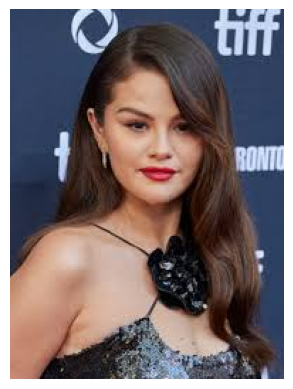

C:\Users\mahen\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mahen\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\mahen/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|████████████████████████████████████████████████████████████████████████████████| 104M/104M [01:57<00:00, 930kB/s]


Visages détectés : 1
Les yeux n'ont pas été correctement détectés pour aligner le visage.


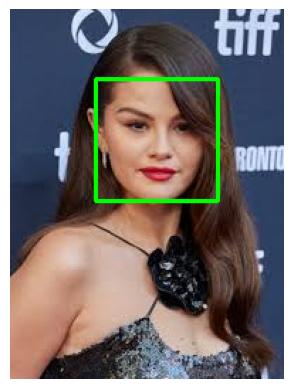

In [14]:
process_face_extraction_opencv(image)

In [15]:
image2="C:/Users/mahen/Intranet/Modele_IA/images/profil_picture/selena_profile_picture2.jpg"

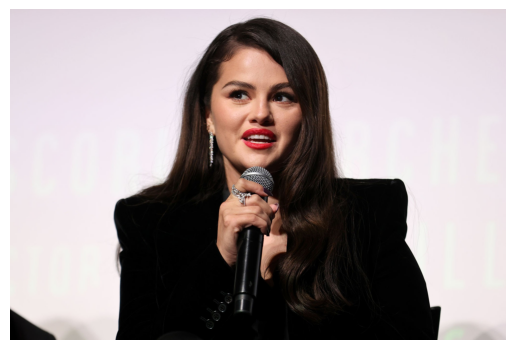

Visages détectés : 1


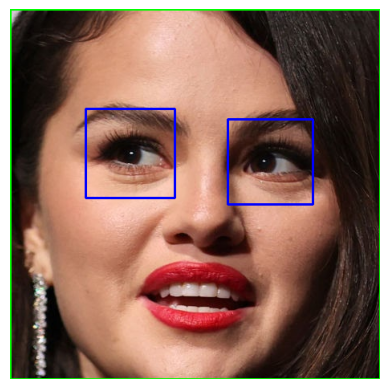

Embeddings extraits pour un visage aligné : tensor([[0.1129, 0.4832, 0.1588,  ..., 0.0980, 0.2534, 0.4085]])
Taille des embeddings : torch.Size([1, 2048])


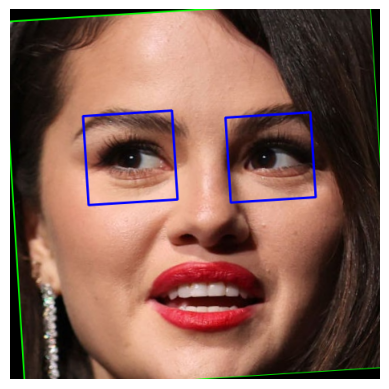

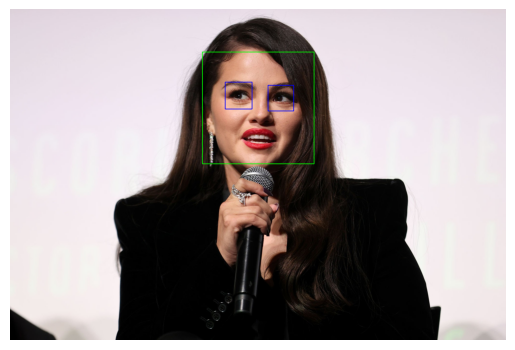

In [16]:
process_face_extraction_opencv(image2)

In [17]:
images = "C:/Users/mahen/Intranet/Modele_IA/images/picture/selena_picture_1.jpg"

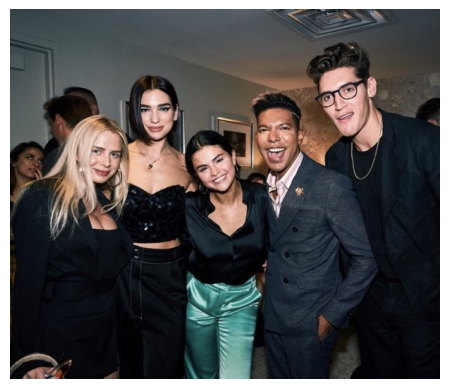

Visages détectés : 5
Les yeux n'ont pas été correctement détectés pour aligner le visage.
Les yeux n'ont pas été correctement détectés pour aligner le visage.
Les yeux n'ont pas été correctement détectés pour aligner le visage.
Les yeux n'ont pas été correctement détectés pour aligner le visage.
Les yeux n'ont pas été correctement détectés pour aligner le visage.


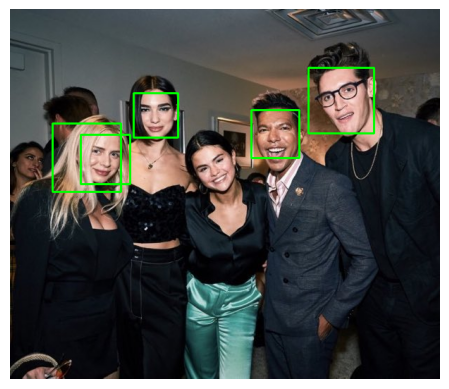

In [18]:
process_face_extraction_opencv(images)

In [19]:
images2 = "C:/Users/mahen/Intranet/Modele_IA/images/picture/selena_picture_2.jpg"

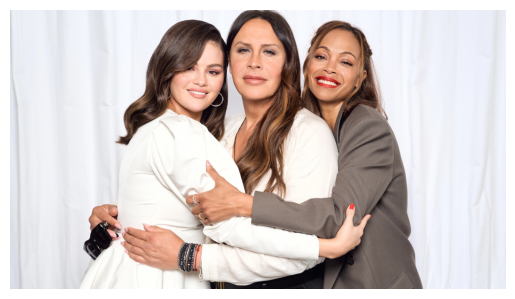

Visages détectés : 3


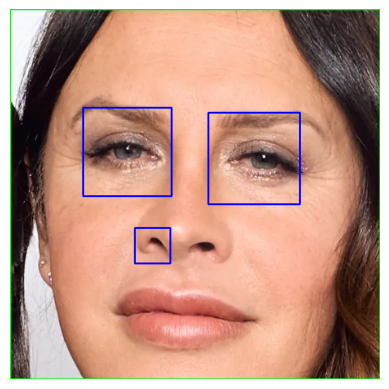

Embeddings extraits pour un visage aligné : tensor([[0.9133, 0.4130, 0.1897,  ..., 1.1732, 0.0175, 0.6057]])
Taille des embeddings : torch.Size([1, 2048])


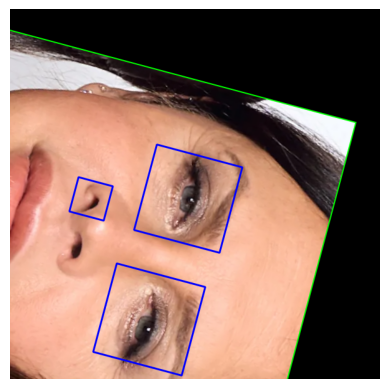

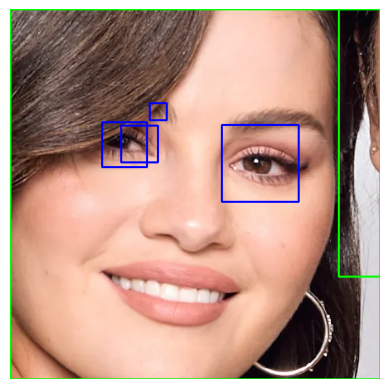

Embeddings extraits pour un visage aligné : tensor([[0.1947, 0.7151, 0.1653,  ..., 0.2392, 0.3501, 0.6837]])
Taille des embeddings : torch.Size([1, 2048])


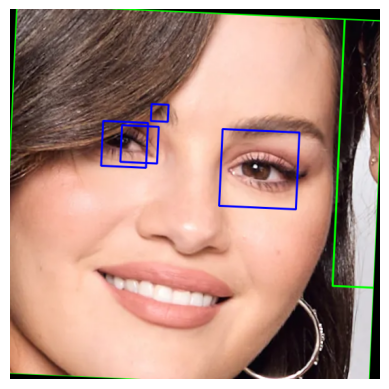

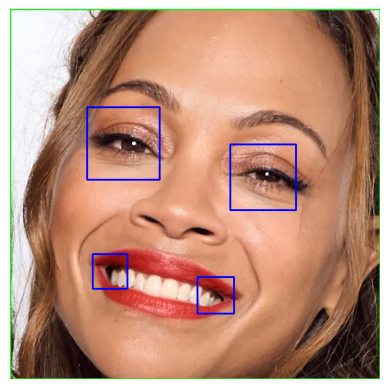

Embeddings extraits pour un visage aligné : tensor([[0.7105, 0.2761, 0.0305,  ..., 0.7136, 0.1971, 0.8363]])
Taille des embeddings : torch.Size([1, 2048])


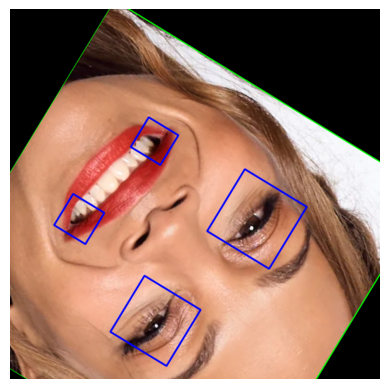

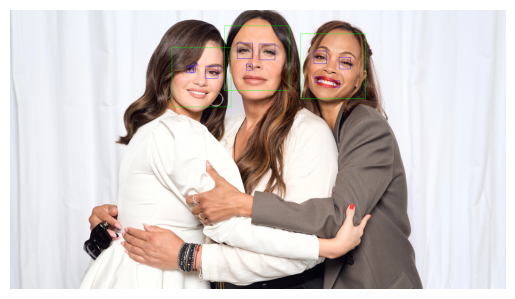

In [20]:
process_face_extraction_opencv(images2)